주요 어휘 추출 전처리 후 페이지 추천 기능 적용

1. 전처리 코드 완성(디버깅 포함, 워드클라우드 생성)

※ 라이브러리 및 프레임워크 필요시 설치

!pip install konlpy

!pip install JPype1

!pip install wordcloud matplotlib

!pip install --upgrade pip

!pip install --upgrade Pillow

In [1]:
import pandas as pd
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
# 데이터 로드
df = pd.read_csv("data/wanted_crawling_all_data.csv", index_col=None, 
                 parse_dates=['Title', 'URL'], encoding='cp949')

In [4]:
# 불용어 리스트를 파일에서 읽어오기
with open('stopwords-ko.txt', 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

In [5]:
# 형태소 분석기 초기화
okt = Okt()

In [6]:
# 전처리 함수 정의 (명사 추출 및 불용어 제거)
def preprocess_text(text):
    if isinstance(text, str):  # 문자열 데이터만 처리
        text = text.lower()
        text = re.sub(r'\d+', '', text)  # 숫자 제거
        text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
        # 명사 추출
        nouns = okt.nouns(text)
        # 불용어 제거
        filtered_nouns = [noun for noun in nouns if noun not in stopwords and len(noun) > 1]
        return ' '.join(filtered_nouns)
    return ''

In [7]:
# TF-IDF 기반 중요 단어 추출 함수
def get_important_words(column_text, n=50):
    vectorizer = TfidfVectorizer(max_features=n, max_df=0.85, min_df=1) 
    X = vectorizer.fit_transform(column_text)
    if X.shape[0] == 0:  # 문서가 없는 경우
        return []
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = X.toarray().sum(axis=0)
    word_score_pairs = sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)
    return word_score_pairs

In [8]:
# 각 열에 대해 전처리 및 TF-IDF 기반 중요 단어 추출 (URL 칼럼 제외)
important_words_dict = {}

In [9]:
for column in df.columns:
    # 해당 칼럼은 처리하지 않음
    if column in ['Title', 'Company', 'Career', 'Deadline', 'Location', 'Duty', 'URL']:
        continue
    if df[column].dtype == 'object':  # 문자열 데이터에 대해서만 처리
        # 전처리 및 명사 추출
        df[column] = df[column].apply(preprocess_text)
        column_text = df[column].dropna().tolist()  # NaN 값 제거 및 리스트로 변환
        
        # 텍스트 샘플 출력 (디버깅용)
        print(f"Column: {column}")
        print("Sample Texts:")
        print(column_text[:5])  # 상위 5개 텍스트 샘플 출력
        
        if len(column_text) > 0:  # 데이터가 있는 경우에만 처리
            # TF-IDF 기반 중요 단어 추출
            important_words = get_important_words(column_text, n=50)
            if important_words:  # 중요 단어가 추출된 경우에만 처리
                important_words_dict[column] = important_words

Column: Work
Sample Texts:
['주요 책임 글로벌 유저 대상 게임 플랫폼 개발 플랫폼 서비스 운영 지속 개선 게임 서비스 백오피스 기능 개발 도화주 환경 프로젝트 일정 집중 기간 존재', '합류 토스 레이스 오프라인 결제 시장 디지털 혁신 만들기 위해 매장 운영 문제 해결 레이스 초창 멤버 로서 오프라인 결제 시장 마주 도전 문제 처음 고민 개발 사장 대시보드 홈페이지 웹사이트 토스 결제 단말기 서비스 웹뷰 모든 플랫폼 기술 이용 사용자 향상 위해 토스 공통 라이브러리 제작 기여', '프레임워크 개발 유지 보수 자사 솔루션 백오피스 비롯 마이크로 사이트 개발 유지 보수 활용 데이터 바인 렌더링 설계 구현', '모바일 게임 마피아 서버 개발자 채팅 모바일 온라인 게임 서버 개발', '제휴 파트너 효과 테크 서비스 개발 성장 중인 트래블 월렛 차세대 외환 결제 백오피스 개발 퍼블릭 웹서비스 개발 운영 백오피스 사내 운영 개발 운영']
Column: Qualification
Sample Texts:
['필수 자격 요건 학력 전공 무관 개발 보유 유저 서비스 개발 보유 이해 지식 보유 라이브러리 프레임워크 활용 개발 관심 선호 자격 요건 개발 언어 로서 이해 언어 강화 위해 노력 환경 모바일 웹뷰 보유 기술 이해 렌더링 개발 배포 스크립트 작성 구축 운용 지식 협업 실무 보유 디자인 시스템 실무 보유 웹사이트 성능 최적화 분필 효과 커뮤니케이션 여러 유관 부서 외부 관계자 협업 협력 사고 통합 관점 목표 의식 주도 추진 문제 파악 분석 적극 선제 문제해결 책임감 결과물 품질 완성 기준', '분과 프레임워크 사용 개발 주도 문제 발견 분석 해결 이용 정적 타입 분석', '이해 프론트엔드 프레임워크 이해 개발 의사소통 협업', '자료구조 알고리즘 운영체제 네트워크 컴퓨터 학적 지식 언어 지식 설계 개발 포트폴리오 제출 필수', '관련 개발 실력 보유 활용 어플리케이션 평소 사용 사용 커뮤니케이션']
Column: Addition
Sample Texts

In [10]:
# 각 칼럼별 중요 단어를 CSV 파일로 저장
for column, words in important_words_dict.items():
    df_words = pd.DataFrame(words, columns=['Word', 'Score'])
    df_words.to_csv(f'{column}_important_words.csv', index=False, encoding='utf-8-sig')

In [11]:
# 전처리된 텍스트 확인 (디버깅용)
for column in df.columns:
    if column in important_words_dict:
        print(f"Column: {column}")
        print(df[column].head())

Column: Work
0    주요 책임 글로벌 유저 대상 게임 플랫폼 개발 플랫폼 서비스 운영 지속 개선 게임 ...
1    합류 토스 레이스 오프라인 결제 시장 디지털 혁신 만들기 위해 매장 운영 문제 해결...
2    프레임워크 개발 유지 보수 자사 솔루션 백오피스 비롯 마이크로 사이트 개발 유지 보...
3                모바일 게임 마피아 서버 개발자 채팅 모바일 온라인 게임 서버 개발
4    제휴 파트너 효과 테크 서비스 개발 성장 중인 트래블 월렛 차세대 외환 결제 백오피...
Name: Work, dtype: object
Column: Qualification
0    필수 자격 요건 학력 전공 무관 개발 보유 유저 서비스 개발 보유 이해 지식 보유 ...
1            분과 프레임워크 사용 개발 주도 문제 발견 분석 해결 이용 정적 타입 분석
2                         이해 프론트엔드 프레임워크 이해 개발 의사소통 협업
3    자료구조 알고리즘 운영체제 네트워크 컴퓨터 학적 지식 언어 지식 설계 개발 포트폴리...
4                관련 개발 실력 보유 활용 어플리케이션 평소 사용 사용 커뮤니케이션
Name: Qualification, dtype: object
Column: Addition
0    조직 문화 자율 출퇴근 무제한 연차 휴가 스스로 관리 의견 교환 상호 신뢰 근거 수...
1    이력서 작성 추천 플랫폼 관련 공통 서비스 공통 라이브러리 구현 운영 해당 진행 이...
2        이해 관심 사용 성능 최적화 관심 이해 테스트 자동화 단위 테스트 라이브러리 모듈
3    게임 웹앱 온라인 서비스 백엔드 개발 용량 부하 시스템 설계 운영 리눅스 운영 서버...
4    배포 클라우드 배포 환경 이해 프론트엔드 개발 방법 이해 개발 디자인 시스템 재사용...
Name: Addition, dtype: object
Column: Welfare
0               

In [12]:
# 전처리된 데이터프레임 저장
df.to_csv('preprocessed_data_all.csv', index=False, encoding='utf-8-sig')

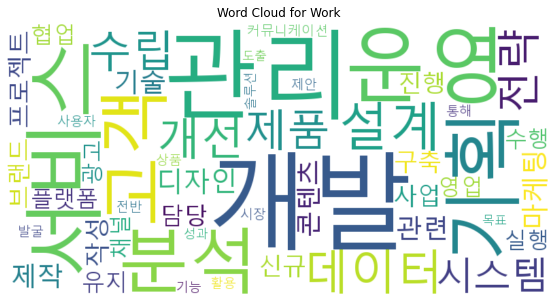

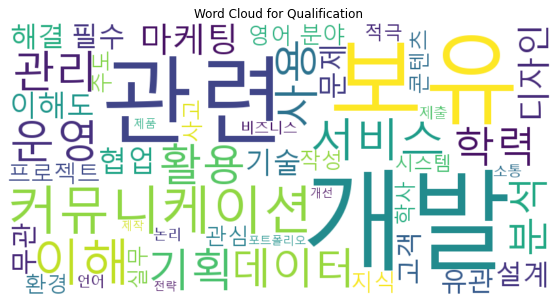

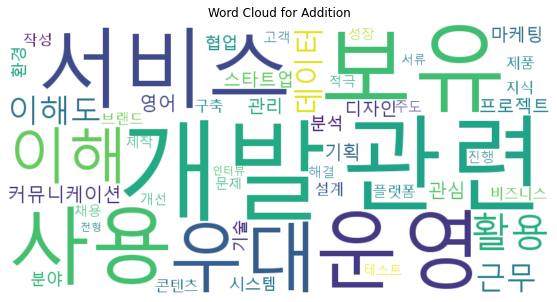

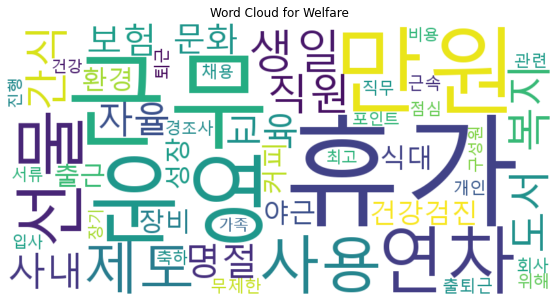

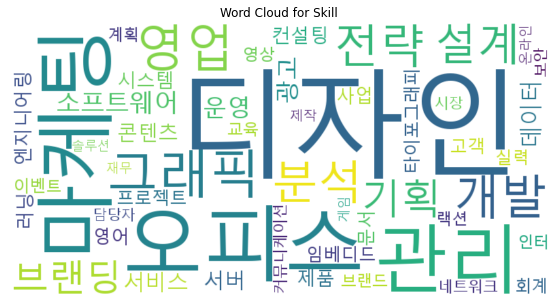

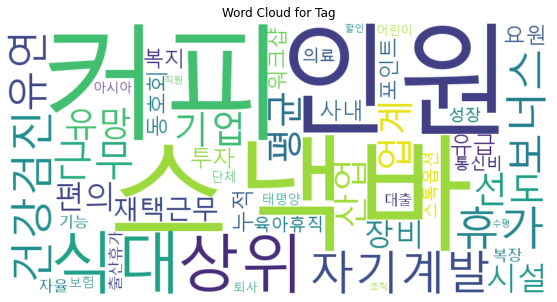

In [13]:
# 워드클라우드 생성 및 저장 함수
def create_wordcloud(words, column_name):
    word_freq = dict(words)  # 중요 단어와 점수를 딕셔너리 형태로 변환
    wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',  # 한글 폰트 경로
                          width=800, height=400, 
                          background_color='white').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column_name}')
    plt.savefig(f'{column_name}_wordcloud.png', format='png')
    plt.show()

# 각 칼럼별 워드클라우드 생성 및 저장
for column, words in important_words_dict.items():
    create_wordcloud(words, column)

2. 전처리 데이터 추천기능 적용

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
# 데이터 로드
df = pd.read_csv("data/wanted_crawling_all_data.csv", index_col=None, encoding='cp949')

In [16]:
# 불용어 리스트를 파일에서 읽어오기
with open('stopwords-ko.txt', 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

# 전처리 함수 정의 (명사 추출 및 불용어 제거)
def preprocess_text(text, okt):
    if isinstance(text, str):  # 문자열 데이터만 처리
        text = text.lower()
        text = re.sub(r'\d+', '', text)  # 숫자 제거
        text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
        # 명사 추출
        nouns = okt.nouns(text)
        # 불용어 제거
        filtered_nouns = [noun for noun in nouns if noun not in stopwords and len(noun) > 1]
        return ' '.join(filtered_nouns)
    return ''

In [17]:
# 형태소 분석기 초기화
from konlpy.tag import Okt
okt = Okt()

In [18]:
# 사용자의 조건을 입력받아 유사한 채용 공고 추천하는 함수
def recommend_jobs(user_query, df, okt, top_n=5):
    # 여러 칼럼을 전처리 (Title, Company, 주요 업무, 기술 스택 등 필요한 칼럼 추가)
    df['preprocessed_title'] = df['Title'].apply(lambda x: preprocess_text(x, okt))
    df['preprocessed_company'] = df['Company'].apply(lambda x: preprocess_text(x, okt))
    df['preprocessed_career'] = df['Career'].apply(lambda x: preprocess_text(x, okt))
    df['preprocessed_work'] = df['Work'].apply(lambda x: preprocess_text(x, okt))
    df['preprocessed_qualification'] = df['Qualification'].apply(lambda x: preprocess_text(x, okt))
    df['preprocessed_addition'] = df['Addition'].apply(lambda x: preprocess_text(x, okt))
    df['preprocessed_welfare'] = df['Welfare'].apply(lambda x: preprocess_text(x, okt))
    df['preprocessed_skill'] = df['Skill'].apply(lambda x: preprocess_text(x, okt))
    df['preprocessed_tag'] = df['Tag'].apply(lambda x: preprocess_text(x, okt))
    df['preprocessed_deadline'] = df['Deadline'].apply(lambda x: preprocess_text(x, okt))
    df['preprocessed_location'] = df['Location'].apply(lambda x: preprocess_text(x, okt))
    df['preprocessed_duty'] = df['Duty'].apply(lambda x: preprocess_text(x, okt))
    
    # 사용자가 입력한 질의를 전처리
    query_preprocessed = preprocess_text(user_query, okt)

    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer()

    # 여러 칼럼을 하나의 텍스트로 결합하여 TF-IDF 계산
    df['combined_text'] = df['preprocessed_title'] + df['preprocessed_company'] + df['preprocessed_career'] + df['preprocessed_work'] + df['preprocessed_qualification'] + df['preprocessed_addition'] + df['preprocessed_welfare'] + df['preprocessed_skill'] + df['preprocessed_tag'] + df['preprocessed_deadline'] + df['preprocessed_location'] + df['preprocessed_duty']
    combined_matrix = vectorizer.fit_transform(df['combined_text'])

    # 사용자의 질의를 벡터화
    query_vector = vectorizer.transform([query_preprocessed])

    # 코사인 유사도 계산
    similarity_scores = cosine_similarity(query_vector, combined_matrix).flatten()

    # 유사도 순으로 상위 N개의 인덱스 추출
    top_indices = similarity_scores.argsort()[-top_n:][::-1]

    # 상위 N개의 회사, 제목, URL을 추천
    recommendations = df[['Title', 'Company', 'URL']].iloc[top_indices]
    return recommendations

In [19]:
# 사용자가 선택한 조건
user_query = "데이터 분석 경력"

# 채용 공고 추천
recommended_jobs = recommend_jobs(user_query, df, okt, top_n=5)

In [20]:
# 추천 결과 출력
print(recommended_jobs)

                      Title Company                                 URL
2418        데이터 분석가 (3년 이상)   클라이원트  https://www.wanted.co.kr/wd/225337
2121                데이터 분석가      브릭  https://www.wanted.co.kr/wd/206929
2349  시니어 데이터 아키텍트/데이터 엔지니어      휴톰  https://www.wanted.co.kr/wd/237665
1198                데이터 분석가    플래티어  https://www.wanted.co.kr/wd/177463
3556            데이터 분석 컨설턴트    교보문고  https://www.wanted.co.kr/wd/149962
